# Data Challenge 7 — Evaluating SLR, Assumptions, & the Bias–Variance Tradeoff

**Goal:** Fit a simple linear regression (SLR) with a **train–test split**, report **MAE/RMSE** on *unseen* data, and use **training residuals** to check assumptions. Explain **bias vs. variance** in plain English.


> Dataset: **NYC Yellow Taxi — Dec 2023** (CSV). Keep code *simple* — minimal coercion for chosen columns only.

## We Do — Instructor Session (20 mins)
Use this **step-by-step plan** to guide students. Keep it high-level; they will implement in the *You Do* section.

**Docs (quick links):**
- Train/Test Split — scikit-learn: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html
- MAE / MSE / RMSE — scikit-learn: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_absolute_error.html
- OLS (fit/predict/residuals) — statsmodels: https://www.statsmodels.org/stable/generated/statsmodels.regression.linear_model.OLS.html
- OLS Results (attributes like `resid`, `fittedvalues`, `summary`) — statsmodels: https://www.statsmodels.org/stable/generated/statsmodels.regression.linear_model.RegressionResults.html
- Q–Q plot — SciPy: https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.probplot.html

### Pseudocode Plan
1) **Load CSV** → preview columns/shape.
2) **Assign Y and X (one predictor)** → pick numeric columns that matter; if needed, coerce **just** these to numeric and drop NAs.
3) **Add intercept** → `X = add_constant(X)`.
4) **Train–test split (80/20)** → `X_train, X_test, y_train, y_test = train_test_split(...)` (set `random_state`).
5) **Fit on TRAIN** → `model = OLS(y_train, X_train).fit()`.
6) **Predict on TEST** → `y_pred = model.predict(X_test)`.
7) **Evaluate on TEST** → compute **MAE** and **RMSE** using `y_test` & `y_pred`; speak in **units of Y**.
8) **Diagnostics on TRAIN** → use `model.resid` & `model.fittedvalues` for residuals vs fitted; Q–Q plot; check Durbin–Watson in `model.summary()`.
9) **Bias–variance read (optional)** → compare train vs test errors.
10) **Stakeholder one-liner** → MAE/RMSE in units + brief reliability note.


## You Do — Student Section
Work in pairs. Keep code simple and comment your choices.

### Step 0 — Setup & Imports

In [2]:
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from statsmodels.api import add_constant

### Step 1 & 2 — Read in the file and Choose **Y** (target) and **X** (one predictor)
- Keep them numeric and present in your CSV.

**Hint: You may have to drop missing values and do a force coercion to make sure the variables stay numeric (other coding assignments may help)**

In [3]:
df = pd.read_csv('/Users/ayemaq/Desktop/marcy_lab/DA2025_Lectures/Mod6/data/2023_Yellow_Taxi_Trip_Data_20251015.csv')


/var/folders/v2/9k8drrwj5h39kpr935vvx6j80000gn/T/ipykernel_1101/1111186147.py:1: DtypeWarning: Columns (4,10,13,16) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/Users/ayemaq/Desktop/marcy_lab/DA2025_Lectures/Mod6/data/2023_Yellow_Taxi_Trip_Data_20251015.csv')


In [4]:
df.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
0,2,12/01/2023 04:11:39 PM,12/01/2023 04:19:13 PM,2.0,0.69,1.0,N,141,140,1,7.9,2.5,0.5,3.0,0.0,1.0,17.4,2.5,0.0
1,1,12/01/2023 04:11:39 PM,12/01/2023 04:20:41 PM,3.0,1.1,1.0,N,236,263,2,10.0,5.0,0.5,0.0,0.0,1.0,16.5,2.5,0.0
2,2,12/01/2023 04:11:39 PM,12/01/2023 04:20:38 PM,1.0,1.57,1.0,N,48,239,4,-10.7,-2.5,-0.5,0.0,0.0,-1.0,-17.2,-2.5,0.0
3,2,12/01/2023 04:11:39 PM,12/01/2023 04:20:38 PM,1.0,1.57,1.0,N,48,239,4,10.7,2.5,0.5,0.0,0.0,1.0,17.2,2.5,0.0
4,1,12/01/2023 04:11:39 PM,12/01/2023 04:34:39 PM,2.0,3,1.0,N,164,211,1,21.9,5.0,0.5,3.0,0.0,1.0,31.4,2.5,0.0


In [5]:
df.keys()

Index(['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
       'passenger_count', 'trip_distance', 'RatecodeID', 'store_and_fwd_flag',
       'PULocationID', 'DOLocationID', 'payment_type', 'fare_amount', 'extra',
       'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge',
       'total_amount', 'congestion_surcharge', 'airport_fee'],
      dtype='object')

In [6]:
# y will be tolls_amount and x will be airport_fee

# Select relevant columns
df_model = df[['tolls_amount', 'airport_fee']]

# Replace inf values with NaN
df_model = df_model.replace([np.inf, -np.inf], np.nan)

# Drop missing rows
df_model = df_model.dropna()


In [7]:
# This is the input we think explains Y. Here, whether a trip had an airport fee.
X = sm.add_constant(df_model[['airport_fee']]) 

# This is the thing we want to predict, how much toll cost a trip has.
y = df_model['tolls_amount']

### Step 3 — Train–Test Split (80/20 random split for practice)

In [8]:
from sklearn.model_selection import train_test_split

In [9]:
# train test split , doing 80;20 split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


### Step 4 — Fit on TRAIN only; Evaluate on TEST
Compute **MAE** and **RMSE** in the **units of Y**.

In [10]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
# Fit the model
model = sm.OLS(y_train, X_train).fit()

In [11]:
# Evaluate the model on the unseen testing data 
predictions = model.predict(X_test)

mae = mean_absolute_error(y_test, predictions)
rmse = np.sqrt(mean_squared_error(y_test, predictions))

print(f"\nMean Absolute Error (MAE) on Test Data: {mae:.2f}")
print(f"Root Mean Squared Error (RMSE) on Test Data: {rmse:.2f}")
print(f"\nInterpretation: Our model's predictions on new data are off by an average of ${mae:.2f}.")
            


Mean Absolute Error (MAE) on Test Data: 0.79
Root Mean Squared Error (RMSE) on Test Data: 1.97

Interpretation: Our model's predictions on new data are off by an average of $0.79.


When this model tries to predict toll amounts for unseen trips, it’s off by about 79 cents on average.

In [12]:
# summary of the model
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:           tolls_amount   R-squared:                       0.220
Model:                            OLS   Adj. R-squared:                  0.220
Method:                 Least Squares   F-statistic:                 7.070e+05
Date:                Thu, 30 Oct 2025   Prob (F-statistic):               0.00
Time:                        12:16:32   Log-Likelihood:            -5.2624e+06
No. Observations:             2506821   AIC:                         1.052e+07
Df Residuals:                 2506819   BIC:                         1.052e+07
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.2798      0.001    215.733      

### Step 5 — Diagnostic Plots (TRAIN residuals)
Check regression assumptions using **training** residuals.
- **Homoscedasticity:** random cloud around 0 (no cone).
- **Normality:** Q–Q plot ~ diagonal.

Text(0, 0.5, 'Residuals (from Training Data)')

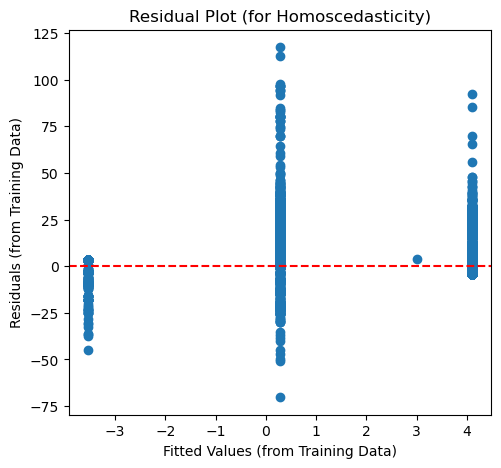

In [13]:
train_residuals = model.resid 

# plot  for homoscedasticity
plt.figure(figsize=(12, 5)) 
plt.subplot(1, 2, 1)
plt.scatter(model.fittedvalues, train_residuals)
plt.axhline(0, color='red', linestyle='--')
plt.title('Residual Plot (for Homoscedasticity)')
plt.xlabel('Fitted Values (from Training Data)')
plt.ylabel('Residuals (from Training Data)')


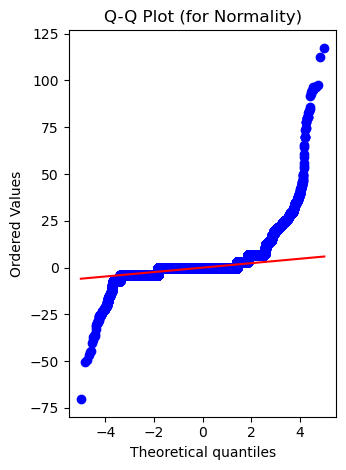

                            OLS Regression Results                            
Dep. Variable:           tolls_amount   R-squared:                       0.220
Model:                            OLS   Adj. R-squared:                  0.220
Method:                 Least Squares   F-statistic:                 7.070e+05
Date:                Thu, 30 Oct 2025   Prob (F-statistic):               0.00
Time:                        12:16:36   Log-Likelihood:            -5.2624e+06
No. Observations:             2506821   AIC:                         1.052e+07
Df Residuals:                 2506819   BIC:                         1.052e+07
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.2798      0.001    215.733      

In [14]:
# 2. Q-Q Plot for Normality
plt.subplot(1, 2, 2)
stats.probplot(train_residuals, dist="norm", plot=plt)
plt.title('Q-Q Plot (for Normality)')

plt.tight_layout()
plt.show()

# 3. Durbin-Watson statistic is in the summary output below
print(model.summary())
            


note to self: We have the assumption of normal data, when we get ht s shape, part of it is that the middle part of the dstiturbiton, is simialr to normail distuibution, but hte tail are thickers, so that hte part of the s i s akigned iwth the line on top m those are both normal but ur tails are differeing sp if it were perfect it owuld match the line. 

### Step 6 — Quick Bias–Variance Read (optional)
Compare **train** and **test** errors and describe what you see.



In [15]:
train_predictions = model.predict(X_train)
train_mae = mean_absolute_error(y_train, train_predictions)
train_rmse = np.sqrt(mean_squared_error(y_train, train_predictions))

print(f"Train MAE: {train_mae:.2f}")
print(f"Test MAE: {mae:.2f}")
print(f"Train RMSE: {train_rmse:.2f}")
print(f"Test RMSE: {rmse:.2f}")


Train MAE: 0.79
Test MAE: 0.79
Train RMSE: 1.97
Test RMSE: 1.97


- The training set (how well it learned known data)
- The test set (how well it generalizes to new data)

The model performs consistently on both training and testing data, with identical MAE (0.79) and RMSE (1.97). This suggests it generalizes well and avoids overfitting or underfitting. In other words, the model’s predictions on new taxi data are off by about 79 cents on average, which is fairly accurate for predicting toll amounts based on airport fees alone.

However, since the model only uses one variable (airport_fee), it may not capture other important factors that influence tolls, like trip distance or time of day. 


## We Share — Reflection & Wrap‑Up
Write **1–2 short paragraphs** addressing:


1) **Is this model good enough** for a real decision **right now**? Why/why not?
Refer to **MAE/RMSE in units**, any **assumption issues**, and whether accuracy meets a reasonable business threshold.


2) **What’s your next move** to improve trust/accuracy?
Examples: adopt a **time‑aware split**, try a more relevant **X**, transform variables, segment checks (hour/zone), or move to **Multiple Linear Regression** with validation.

### Answer
1.  The model performs well, with nearly identical MAE and RMSE on both training and testing data (0.79 and 1.97). This means it generalizes consistently and isn’t overfitting or underfitting. However, it’s not strong enough for a real-world decision just yet because it only uses one predictor (airport_fee), which limits its explanatory power. Toll amounts are also influenced by trip distance, route, and congestion, which aren’t included here. So, while it’s a good starting point, it’s too simple for business use at this stage.

2. To strengthen trust in this model, I’d move to a Multiple Linear Regression that includes additional predictors like trip_distance, time_of_day, or pickup_borough. This would help capture more real-world variation and improve accuracy. I’d also perform validation checks such as time-based splits or segmenting by airport routes to ensure the model performs consistently across different trip patterns.